# Autoencoder to denoise the MNIST dataset using Keras and PyTorch

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras
from keras import layers
from keras.callbacks import ModelCheckpoint, TensorBoard

import torch
from torch import nn, optim
from torchvision import datasets, transforms

from skimage import io
from skimage.util import random_noise

import matplotlib.pyplot as plt
import numpy as np
import sys
import random

In [2]:
latent_dim = 10
batch_size = 128
fit_verbosity = 1

## Create a noisy dataset from the source data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Grayscale()
])

def noisy_transform(data):
    new_data = np.copy(data)
    # Add noise to a clean dataset of images only (no labels)

    for i, img in enumerate(new_data):
        img=random_noise(img, mode='gaussian', mean=0, var=0.3)
        img=random_noise(img, mode='s&p', amount=0.2, salt_vs_pepper=0.5)
        img=random_noise(img, mode='poisson') 
        img=random_noise(img, mode='speckle', mean=0, var=0.1)
        new_data[i] = img
    return new_data

alpha = 0.1 # proportion of the full dataset to use

train_dataset = datasets.MNIST(root="../1-CNN/data", train=True, download=True, transform=transform).data
train_sample = random.sample(range(0, len(train_dataset)), int(alpha *len(train_dataset)))
train_dataset = train_dataset[train_sample] / 255.

test_dataset = datasets.MNIST(root="../1-CNN/data", train=False, download=True, transform=transform).data
test_sample = random.sample(range(0, len(test_dataset)), int(alpha *len(test_dataset)))
test_dataset = test_dataset[test_sample] / 255.

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

noisy_train = noisy_transform(train_dataset)
noisy_test = noisy_transform(test_dataset)


## Build the model

Encoder

In [4]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,178 (270.23 KB)

 Trainable params: 69,178 (270.23 KB)

 Non-trainable params: 0 (0.00 B)

Decoder

In [5]:
inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3136)           │        34,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,177 (352.25 KB)

 Trainable params: 90,177 (352.25 KB)

 Non-trainable params: 0 (0.00 B)

Autoencoder model

In [6]:
inputs = keras.Input(shape=(28, 28, 1))

latents = encoder(inputs)
outputs = decoder(latents)

ae = keras.Model(inputs,outputs, name="ae")

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')

## Training

In [7]:
history = ae.fit(noisy_train, train_dataset,
                 batch_size = batch_size,
                 epochs = 20,
                 verbose = fit_verbosity,
                 validation_data = (noisy_test, test_dataset))

Epoch 1/20
 1/47 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.6931

c:\Users\mathi\miniconda3\envs\ml-projects\lib\site-packages\keras\src\backend\common\backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.3997 - val_loss: 0.2703
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.2681 - val_loss: 0.2657
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.2655 - val_loss: 0.2644
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.2642 - val_loss: 0.2635
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.2618 - val_loss: 0.2585
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.2536 - val_loss: 0.2464
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.2438 - val_loss: 0.2349
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.2288 - val_loss: 0.2180
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.2132 - val_loss: 0.2061
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.2043 - val_loss: 0.1997
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.1990 - val_loss: 0.1962
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.1950 - val

## Evaluating the model

Training loss: 		0.1750
Test loss: 	0.1790


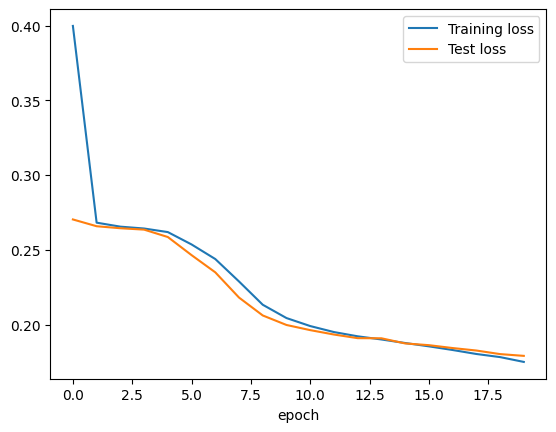

In [8]:
history = history.history
print(f"Training loss: \t\t{min(history['loss']):4.4f}")
print(f"Test loss: \t{min(history['val_loss']):4.4f}")

plt.plot(history['loss'], label="Training loss")
plt.plot(history['val_loss'], label="Test loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

## Show some denoised images

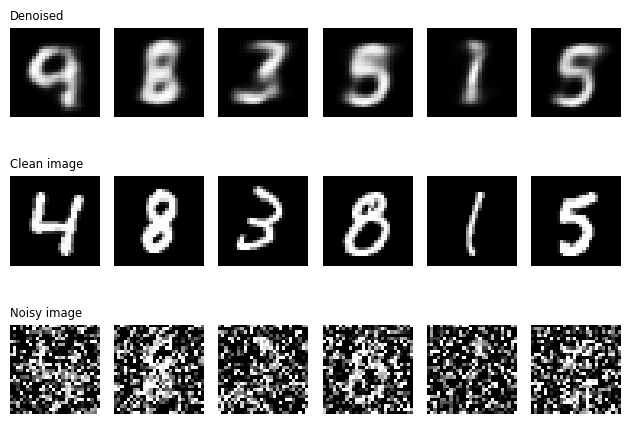

In [17]:
denoised_test = ae.predict(noisy_test, verbose=0)

n = 6
subset = np.random.choice(range(len(noisy_test)), size=n, replace=False)

denoised = denoised_test[subset]
clean = test_dataset[subset]
noised = noisy_test[subset]

fig, axes = plt.subplots(3, n)
for i in range(n):
    axes[0][i].imshow(denoised[i], cmap='gray')
    axes[1][i].imshow(clean[i], cmap='gray')
    axes[2][i].imshow(noised[i], cmap='gray')
    # axes[i].set_title(f'Pred: {classes[subset_predictions[i]]}\nTrue: {classes[subset_labels[i]]}')
    axes[0][i].axis('off')
    axes[1][i].axis('off')
    axes[2][i].axis('off')
axes[0][0].set_title("Denoised", fontsize="small", loc="left")
axes[1][0].set_title("Clean image", fontsize="small", loc="left")
axes[2][0].set_title("Noisy image", fontsize="small", loc="left")
plt.tight_layout()
plt.show()